In [1]:
import os
import numpy as np
import pandas as pd
import random
from matplotlib import rc
import scipy.stats as st
import matplotlib.pyplot as plt
import time
from uncertainties import unumpy
import itertools

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# dataset description
* "time" -- records the date and time of production
* "green -- bar was green("1") or not green("0")
* rest are oompa-loompdas names

In [90]:
df = pd.read_csv("../data/Scrumpulicious.csv")
y = df['GREEN']

df = df.drop(['TIME','GREEN'], axis=1)
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    #dataset.drop(colname, axis=1)
    return dataset
    #print(dataset)
uncorr_df = correlation(df, 0.9)
X = np.array(uncorr_df)
X.shape

(15806, 53)

# Checking for correlation between columns

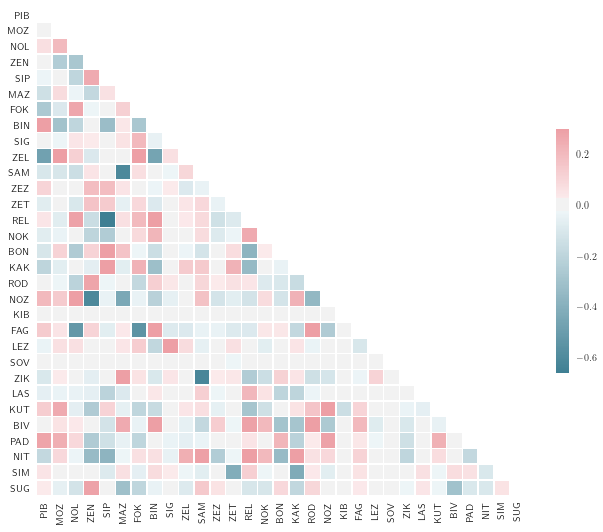

In [3]:
import seaborn as sns
sns.set(style="white")

# Generate a large random dataset
# Compute the correlation matrix
corr = df.corr()
#corr = corr[corr>]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Checking for outliers and normlising data
* checking if columns are correlated
* checking if columns come from the normal distribution, using normal test and the Shapiro-Wilk test
* 

In [5]:
def standardize_data(X):
    sc = StandardScaler()
    fitted = sc.fit(X)
    return sc.transform(X)
X = standardize_data(X)

In [8]:
a = [st.normaltest(X[:,i])[1] for i in range(X.shape[1])]
alpha = 0.05
print((np.array(a)<alpha).all())

True


In [9]:
a = [st.shapiro(X[:,i])[1] for i in range(X.shape[1])]
alpha = 0.05
print((np.array(a)<alpha).all())

True


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Hence non are from the normal distribution

# Now checking quantile plots since its not normal
Given some data, my first line of attack is always a plot. A quantile plot shows (ordered) values plotted against cumulative probabilities, or if you like an implicit rank. Here the original data are clearly all positive and collectively positively skewed (left-hand panel), but a logarithmic scale is thereby suggested. When that is tried (right-hand panel), the data look like a very respectable sample from a lognormal distribution, i.e. the logarithms look like a very respectable sample from a normal distribution. Here "very respectable" means very close to the straight line fit which a perfect sample would show.

In [11]:
from statsmodels.graphics.gofplots import qqplot


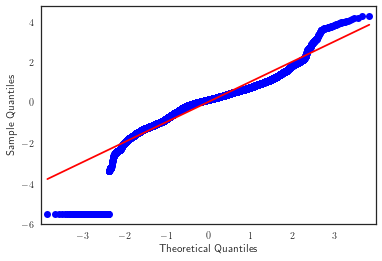

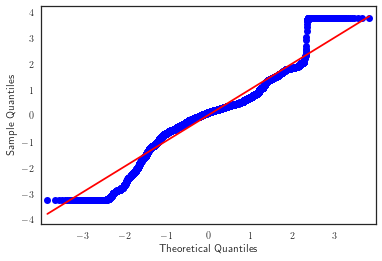

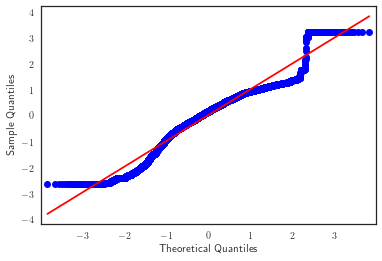

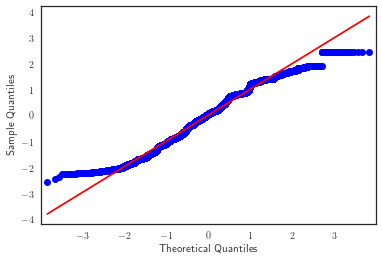

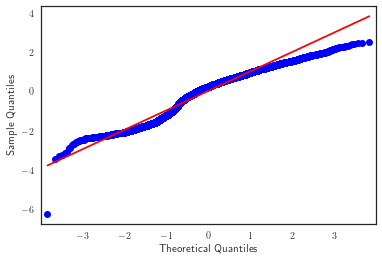

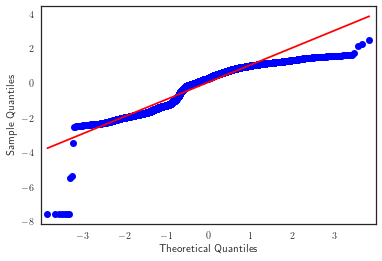

In [12]:
for i in range(6):
    qqplot(X[:,i], line='s')
    plt.title(str())

In [13]:
def scale_set(train,test):
    """uses sklearn standard sclar to normalize data"""
    sc = StandardScaler()
    fitted = sc.fit(train)
    return sc.transform(train), sc.transform(test)

def clssifier_type(X_train, X_test,y_train, y_test, p1=None, p2=None, classifier='SVM'):
    ''' Cross validation of different alogirthms
    p1, p2 - are hyperparameters
    '''
    if classifier=='SVM':
        clf = SVC(probability=True, C=p1,gamma=p2)
    elif classifier=='RANDOM-FOREST':
        clf = RandomForestClassifier(n_estimators=p1, max_depth=p2,random_state=0)

    clf.fit(X_train, y_train)
    y_predict=clf.predict(X_test)
    
    x = {"accuracy": accuracy_score(y_test, y_predict),
         "recall": precision_score(y_test, y_predict),
         "precision": recall_score(y_test, y_predict),
         "f1-score": f1_score(y_test, y_predict, average='weighted', labels=np.unique(y_predict))}
    metrics_output = pd.DataFrame(list(x.values()),index=list(x.keys()),columns=['model']).T
    
    #ROC
    y_score = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc = [fpr, tpr]
    return metrics_output, roc

In [87]:
def model(X, y, n_splits=5, seed=10,model_name='SVM'):
    '''
    Args: X-data, y-labels,
    n_splits - K-fold cross validation splits
    '''
    if model_name=='SVM':
        hp1 = [10]# 10, 100, 1000] #C
        hp2 = [1e-3]#, 1e-2, 1/8] # Gamma
    elif model_name=='RANDOM-FOREST':
        hp1 = [100,200,300] #n_estimators
        hp2 = [2,3,4] #max_depth


    permutations = [(x,y) for x in hp2 for y in hp1]

    kf = StratifiedKFold(n_splits=n_splits,random_state=42, shuffle=True)
    np.random.seed(seed)
    baseline = pd.DataFrame(np.zeros(4)).T
    baseline.columns = ['accuracy','recall','precision','f1-score']

    for p1,p2 in permutations:
        #print("Gamma: {}, C = {}".format(p2,p1))
        empty = pd.DataFrame([],columns=['accuracy','recall','precision','f1-score'])

        tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)

        for train_index, test_index in kf.split(X,y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train, X_test = scale_set(X_train,X_test)

            #metrics calcs
            performance, roc = clssifier_type(X_train, X_test, y_train, y_test, p1, p2, classifier=model_name)
            empty = pd.concat([empty,performance])
            #print(performance)
            #roc curve calcs
            tprs.append(np.interp(mean_fpr, roc[0], roc[1]))
            tprs[-1][0] = 0.0
            roc_auc = auc(roc[0], roc[1])
            aucs.append(roc_auc)

        permuation_performance = empty.mean() #mean of scores for all CVs

        if np.array([permuation_performance['f1-score']])>=np.array([baseline['f1-score']]): #maximizing f1 score
            baseline = pd.DataFrame(unumpy.uarray(permuation_performance, empty.std())).T

            baseline.columns = ['accuracy','recall','precision','f1-score']
            baseline['param 1'],baseline['param 2'] = p1, p2
            tprs_best = tprs
            aucs_best = aucs
            mean_fpr_best = mean_fpr

    r = {"tprs":tprs_best,
         "aucs":aucs_best,
         "mean_fpr":mean_fpr_best,
         "model_name":model_name} #roc

    #returning part
    baseline.insert(0, 'Model', model_name)

    return baseline,r

def plot_roc(rocs,balanced=True):
    '''plots the roc curve for a given model'''
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='cyan',
         label='Luck', alpha=.8)
    colors = ['b','k','r']
    for index, values in enumerate(rocs):
        tprs = values['tprs']
        aucs = values['aucs']
        mean_fpr = values['mean_fpr']
        model_name1 = values['model_name']

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
                 label='{} - AUC = {:.4f} $\pm$ {:.4f}'.format(model_name1, mean_auc, std_auc),
                 lw=2, alpha=.8,color=colors[index])

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2,color=colors[index])


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic of the {} model'.format(mode_name))
    plt.legend(loc="lower right")
    plt.show()



In [15]:
SVM_1_performance, SVM_1_roc = model(X, y,
                                     n_splits=5, seed=42,
                                     model_name='SVM')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted 

In [16]:
SVM_1_performance

,Model,accuracy,recall,precision,f1-score,param 1,param 2
0,SVM,0.99355+/-0.00017,0.0+/-0,0.0+/-0,0.99676+/-0.00009,0.001,10


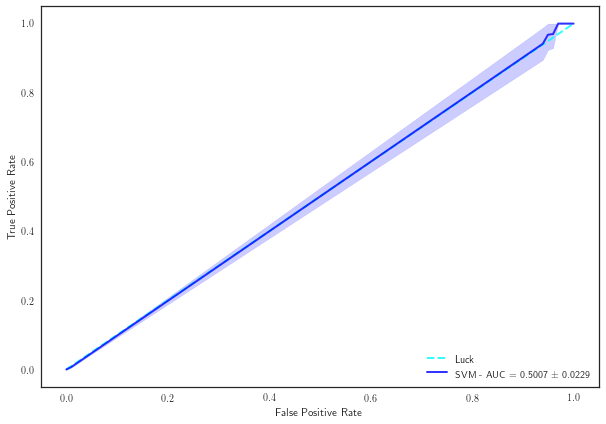

In [17]:
plot_roc([SVM_1_roc])

In [88]:
RM_1_performance, RM_1_roc = model(X_sm, y_sm,
                                   n_splits=5, seed=42,
                                   model_name='RANDOM-FOREST')
RM_1_performance

,Model,accuracy,recall,precision,f1-score,param 1,param 2
0,RANDOM-FOREST,0.9976+/-0.0011,0.9987+/-0.0007,0.9966+/-0.0016,0.9976+/-0.0011,4,100


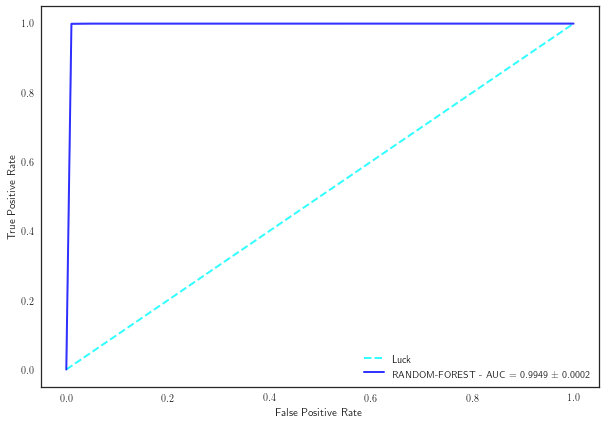

In [89]:
plot_roc([RM_1_roc])

In [85]:
#split into test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

#Normalize data by dividing by std
#X_train, X_test = ml.scale_set(X_train, X_test)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None)
#print(clf.predict(X_test))

pred = clf.predict(X_test) # obliczamy predykcję dla tekstów ze zbioru testowego
accur = accuracy_score(y_test,pred) # dokladność
print("accuracy:   %0.3f" % accur)
print("classification report:",classification_report(y_test,pred)) # wypisz raport klasyfikacji 
print("confusion matrix") # wypisz macierz (confusion matrix)
print(confusion_matrix(y_test,pred))
#print("---------------------------")

accuracy:   0.748
classification report:               precision    recall  f1-score   support

           0       0.68      0.96      0.79      4769
           1       0.93      0.53      0.68      4654

   micro avg       0.75      0.75      0.75      9423
   macro avg       0.80      0.75      0.74      9423
weighted avg       0.80      0.75      0.74      9423

confusion matrix
[[4579  190]
 [2180 2474]]


Firstly, anamoly detection does not look to be the right approach for your use case.

Approach 1: There is a python module to perform under and over sampling with various techniques here. This package includes SMOTE implementation as well. Using this package try to balance event data in your sample before running RandomForest or any other classification algorithms.

Approach 2: If the above does not work well, then firth's bias reduced logistic regression approach with penalized profile likelihood based confidence intervals for parameter estimates will suit your case. You can try L1 (Lasso) regularization on logistic regression from Python scikit library. Alternatively you can try R's 'logistf' package example.

## Re-sampling approach

Class 0: 15704
Class 1: 102
Proportion: 153.96 : 1


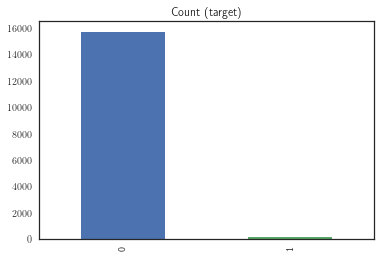

In [54]:
df = pd.read_csv("../data/Scrumpulicious.csv")
df = df.drop("TIME",axis=1)
df_train = df['GREEN']

target_count = df_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df.columns[:-1]

X = df[labels]
y = df['GREEN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.56%


## Resampling

In [56]:
# Class count
count_class_0, count_class_1 = y.value_counts()

# Divide by class
df_class_0 = df[df['GREEN'] == 0]
df_class_1 = df[df['GREEN'] == 1]

### Random under-sampling

Random under-sampling:
1    102
0    102
Name: GREEN, dtype: int64


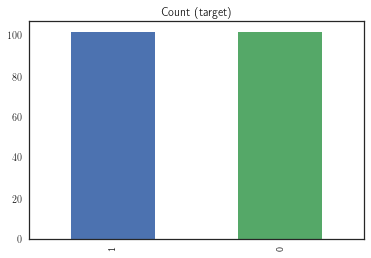

In [62]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['GREEN'].value_counts())

df_test_under['GREEN'].value_counts().plot(kind='bar', title='Count (target)');

### Random over-sampling

Random over-sampling:
1    15704
0    15704
Name: GREEN, dtype: int64


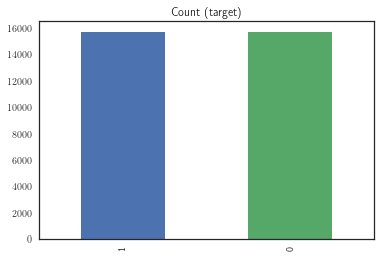

In [63]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over['GREEN'].value_counts())

df_test_over['GREEN'].value_counts().plot(kind='bar', title='Count (target)');

# Imblearn

In [64]:
import imblearn


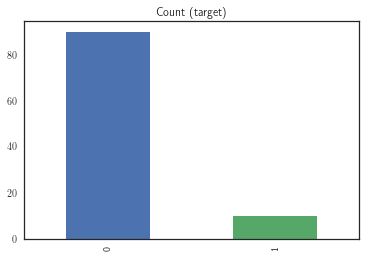

In [65]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [66]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

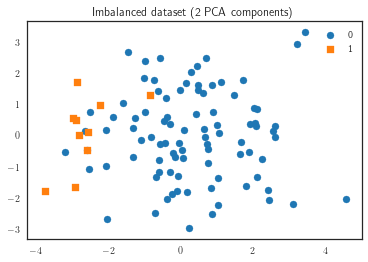

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

## Random under-sampling and over-sampling with imbalanced-learn


Removed indexes: [13 11 49 47 92 63 52 64 99 12  4  8  9 14 16 40 67 70 71 74]


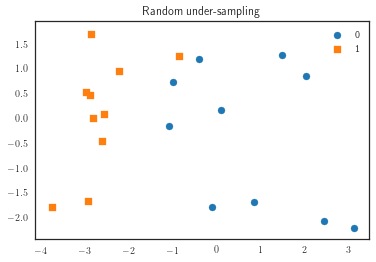

In [68]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


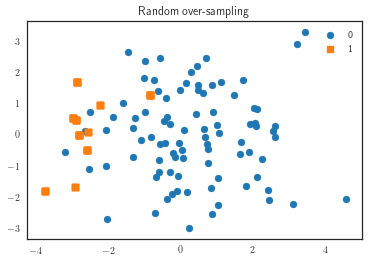

In [69]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

## Under-sampling: Tomek links


Removed indexes: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 90 91 92 93 94 95 97 98 99]


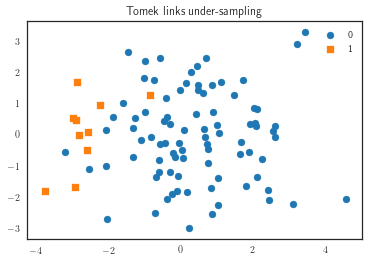

In [71]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

### Under-sampling: Cluster Centroids

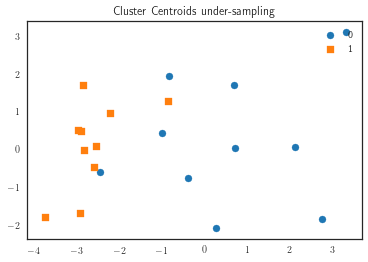

In [73]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 10})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

## Over-sampling: SMOTE


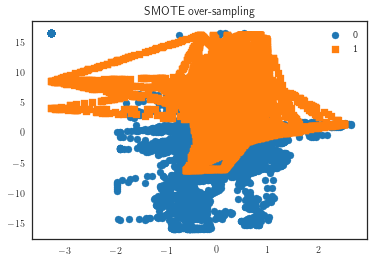

In [81]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [83]:
X_sm.shape


(31408, 53)

In [84]:
y_sm.shape

(31408,)

### Over-sampling followed by under-sampling


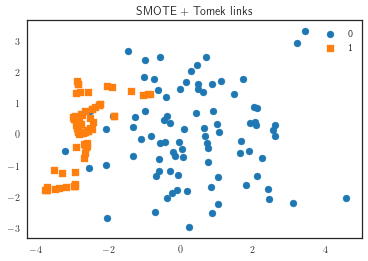

In [75]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

# https://beckernick.github.io/oversampling-modeling/

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [108]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [109]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [113]:
print ('Validation Results')
print (clf_rf.score(X_val, y_val))
print (recall_score(y_val, clf_rf.predict(X_val)))
print ('\nTest Results')
print (clf_rf.score(X_test, y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))

Validation Results
0.9952550415183867
0.45

Test Results
0.9958886780518659
0.4117647058823529


In [111]:
X.shape

(15806, 53)

In [112]:
y.shape

(15806,)